In [1]:
from panel_segmentation import utils
import glob
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import folium
import torch
from mmengine import Config
from mmdet.apis import init_detector, inference_detector
from mmdet.registry import VISUALIZERS
import mmcv
import numpy as np
import geopandas
from shapely.ops import unary_union
from shapely.geometry import Polygon, mapping
import shapely

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


C:\Users\kperry\AppData\Roaming\Python\Python311\site-packages\mmengine\optim\optimizer\zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


# Automatically Geotag a Utility PV Site with Trackers

The following example uses Panel-Segmentation's automated geotagging pipeline to isolate all the trackers rows and inverters on a utility PV site. This data is then aggregated to create master geoJSON file for the site. The PV site used in this example is available from the American-Made Solar Data Bounty Prize (https://www.energy.gov/eere/solar/american-made-solar-data-bounty-prize). Site metadata and performance data is available via the Open Energy Data Initiative (OEDI), under system ID 9068 (https://data.openei.org/submissions/4568).

In [2]:
sys_latitude, sys_longitude = 40.3864,-104.5512
# Set northwest and southeast bounding lat-longitude coordinates to 
# take all of the satellite images of the site
northwest_lat, northwest_lon =  40.388253,-104.554333
southeast_lat, southeast_lon =  40.385272,-104.545799
google_maps_api_key = "YOUR_API_KEY_HERE"
zoom_level = 20
file_save_folder = "../../../panel_segmentation/examples/automated-geotagging_data_examples_tracked_system"
grid_info_list = utils.generateSatelliteImageryGrid(northwest_lat, northwest_lon,
                                                    southeast_lat, southeast_lon,
                                                    google_maps_api_key,
                                                    file_save_folder,
                                                    zoom_level,
                                                    lat_lon_distance=.00067)

File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already 

Visualize the data set in grid format.

40.388253_-104.554333.png
40.387583_-104.554333.png
40.386913_-104.554333.png
40.386243_-104.554333.png
40.385573_-104.554333.png
40.384903_-104.554333.png
40.388253_-104.553663.png
40.387583_-104.553663.png
40.386913_-104.553663.png
40.386243_-104.553663.png
40.385573_-104.553663.png
40.384903_-104.553663.png
40.388253_-104.552993.png
40.387583_-104.552993.png
40.386913_-104.552993.png
40.386243_-104.552993.png
40.385573_-104.552993.png
40.384903_-104.552993.png
40.388253_-104.552323.png
40.387583_-104.552323.png
40.386913_-104.552323.png
40.386243_-104.552323.png
40.385573_-104.552323.png
40.384903_-104.552323.png
40.388253_-104.551653.png
40.387583_-104.551653.png
40.386913_-104.551653.png
40.386243_-104.551653.png
40.385573_-104.551653.png
40.384903_-104.551653.png
40.388253_-104.550983.png
40.387583_-104.550983.png
40.386913_-104.550983.png
40.386243_-104.550983.png
40.385573_-104.550983.png
40.384903_-104.550983.png
40.388253_-104.550313.png
40.387583_-104.550313.png
40.386913_-1

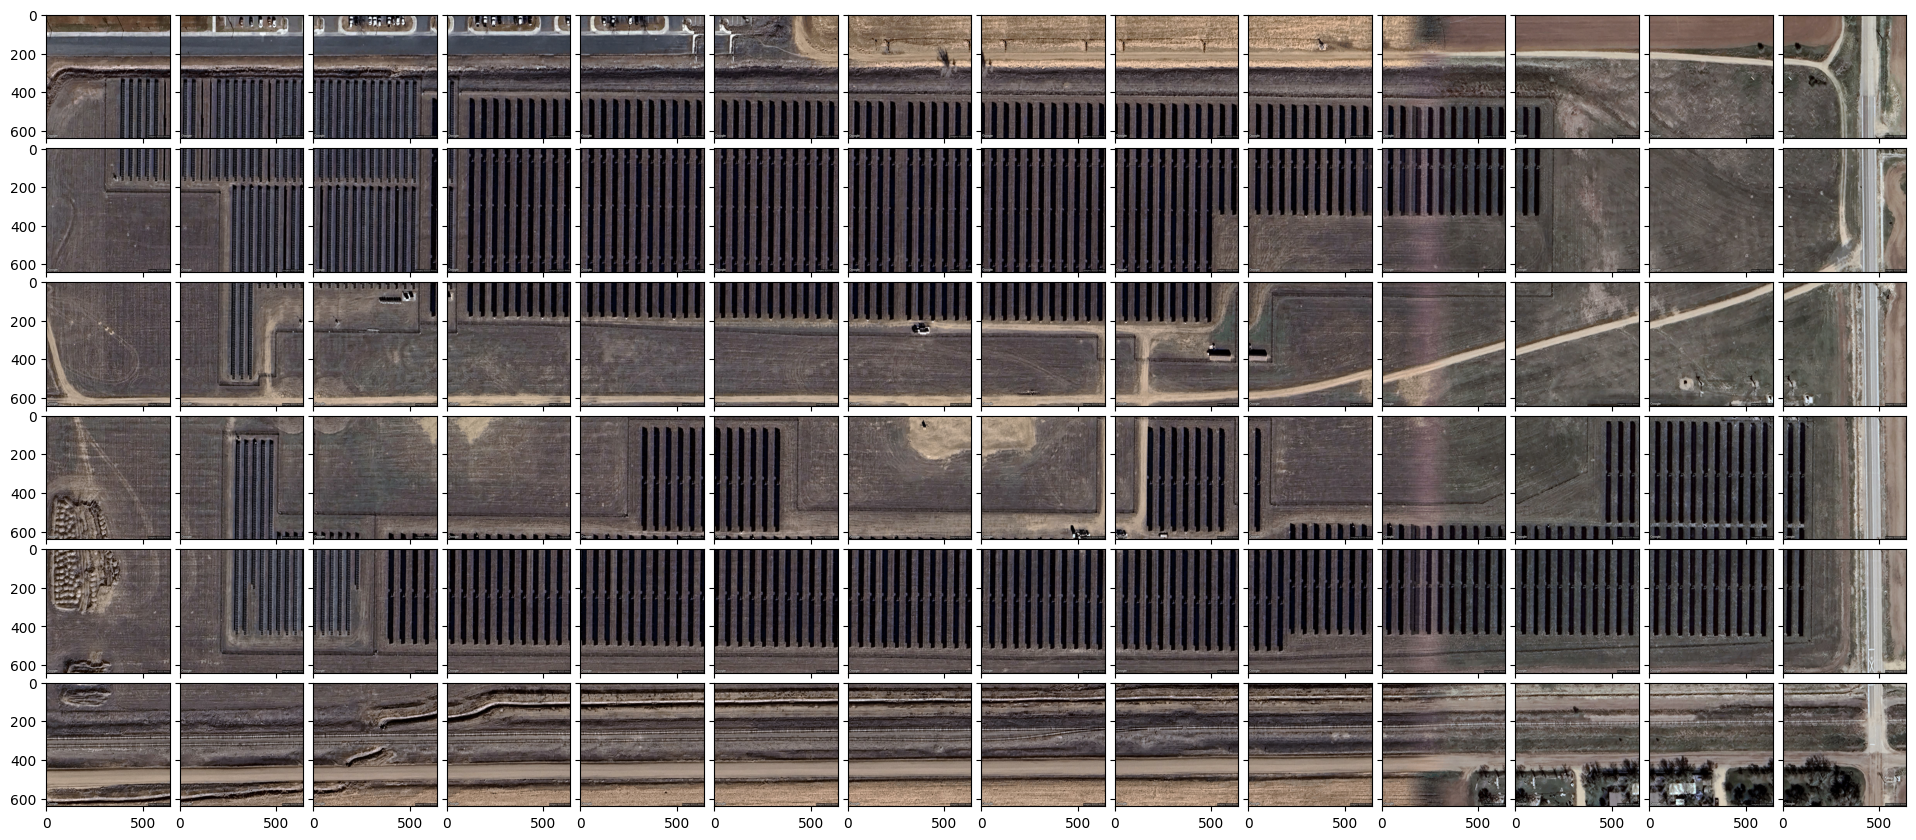

In [3]:
plot = utils.visualizeSatelliteImageryGrid(grid_info_list, file_save_folder)
plt.show()

Load in the automated geotagging CV algorithm. All images will be run through it to identify site equipment.

In [4]:
cfg = Config.fromfile("../../../panel_segmentation/models/automated_geotagging_config.py")
checkpoint_file = "../../../panel_segmentation/models/automated_geotagging_model.pth"
model = init_detector(cfg, device='cpu')
checkpoint = torch.load(checkpoint_file, map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint['state_dict'])
visualizer = VISUALIZERS.build(model.cfg.visualizer)

# Run inference on the example images
inference_data_list = list()
results = list()
grid_files = glob.glob(os.path.join(file_save_folder, "*.png"))
for i, file in enumerate(grid_files):
    img = mmcv.imread(file, channel_order='rgb')
    new_result = inference_detector(model, img)
    new_result.file = file
    results.append(new_result)

c:\users\kperry\documents\source\repos\mmdetection\mmdet\apis\inference.py:70: UserWarning: checkpoint is None, use COCO classes by default.
  warnings.warn('checkpoint is None, use COCO classes by default.')
c:\users\kperry\documents\source\repos\mmdetection\mmdet\models\layers\se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
c:\users\kperry\documents\source\repos\mmdetection\mmdet\models\backbones\csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
C:\Users\kperry\.conda\envs\deep-learning\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\T

Convert all the masks to geoJSON's and merge them into a master geoJSON file.

In [5]:
inference_data_list = list()
for result in results:
    predictions = result._pred_instances
    masks = predictions.masks
    labels = predictions.labels
    scores = predictions.scores
    # Take all labels meeting a 0.3 threshold or greater
    idx_to_keep = np.argwhere(scores>=0.3).tolist()[0]
    file_name = os.path.basename(result.file)
    img_center_lat, img_center_lon = float(file_name.split("_")[0]), float(file_name.split("_")[-1].replace(".png", ""))
    image_x_pixels, image_y_pixels = new_result.img_shape
    # Convert all of the masks to latitude-longitude-based polygons
    for index in range(len(masks)):
            if index in idx_to_keep:
                segmentation_mask = masks[index].data.cpu().numpy()
                # Convert the mask to a polygon
                polygon_lat_lon_coords = utils.convertMaskToLatLonPolygon(segmentation_mask, 
                                                                    img_center_lat, 
                                                                    img_center_lon,
                                                                    image_x_pixels, 
                                                                    image_y_pixels,
                                                                    zoom_level=20)
                # Convert to a geoJSON
                shapely_poly = Polygon(polygon_lat_lon_coords)
                if not shapely.is_valid(shapely_poly):
                    shapely_poly =shapely.make_valid(shapely_poly)
                geojson_poly = geopandas.GeoSeries(shapely_poly).to_json()
                inference_data_list.append({"image": result.file,
                                            "poly": shapely_poly,
                                            "label": int(labels[index])})
inference_df = pd.DataFrame(inference_data_list)
inference_df[inference_df['label']==3].head(20)

image  \
1   ../../../panel_segmentation/examples/automated...   
26  ../../../panel_segmentation/examples/automated...   
27  ../../../panel_segmentation/examples/automated...   
28  ../../../panel_segmentation/examples/automated...   
29  ../../../panel_segmentation/examples/automated...   
30  ../../../panel_segmentation/examples/automated...   
31  ../../../panel_segmentation/examples/automated...   
32  ../../../panel_segmentation/examples/automated...   
33  ../../../panel_segmentation/examples/automated...   
34  ../../../panel_segmentation/examples/automated...   
35  ../../../panel_segmentation/examples/automated...   
36  ../../../panel_segmentation/examples/automated...   
37  ../../../panel_segmentation/examples/automated...   
38  ../../../panel_segmentation/examples/automated...   
39  ../../../panel_segmentation/examples/automated...   
40  ../../../panel_segmentation/examples/automated...   
41  ../../../panel_segmentation/examples/automated...   
42  ../../../panel_segmentation/examples/automated...   
43  ../../../panel_segmentation/examples/automated...   
44  ../../../panel_segmentation/examples/automated...   

                                                 poly  label  
1   POLYGON ((-104.54625818045959 40.3846183046711...      3  
26  POLYGON ((-104.5460220891005 40.38590070284352...      3  
27  POLYGON ((-104.54594039636518 40.3859007030965...      3  
28  POLYGON ((-104.54610684770145 40.3859007033823...      3  
29  POLYGON ((-104.5463546043578 40.38590070351576...      3  
30  POLYGON ((-104.54651932905367 40.3859007033106...      3  
31  POLYGON ((-104.54643763631832 40.3859007034417...      3  
32  POLYGON ((-104.54618854043679 40.3859007034849...      3  
33  POLYGON ((-104.54668405374949 40.3859007028709...      3  
34  POLYGON ((-104.54594078378044 40.3859007029957...      3  
35  POLYGON ((-104.5462715723973 40.38590070353018...      3  
36  POLYGON ((-104.54660102178899 40.3859007031219...      3  
37  POLYGON ((-104.54602381574094 40.3859007032188...      3  
38  POLYGON ((-104.54693219782112 40.3859007035280...      3  
39  POLYGON ((-104.54734467917332 40.3859007029023...      3  
40  POLYGON ((-104.5468491658606 40.38590070347614...      3  
41  POLYGON ((-104.54709826174214 40.3859007034530...      3  
42  POLYGON ((-104.5467661339001 40.38590070336460...      3  
43  POLYGON ((-104.54660140920426 40.3859007029668...      3  
44  POLYGON ((-104.54668444116476 40.3859007031966...      3

Fuse features of the same mask type.

In [6]:
labels = list(inference_df['label'].drop_duplicates())
merged_features = list()
for label in labels:
    inference_label_subset = inference_df[inference_df['label'] == label]
    polygons = list(inference_label_subset['poly'])
    print(label)
    # Run a union for the labels to fuse them all together
    unioned = unary_union(polygons)
    if unioned.geom_type == "Polygon":
        merged_features.append({
                "type": "Feature",
                "properties": {"class": label},
                "geometry": mapping(unioned)
            })
    else:
        for poly in unioned.geoms:
            merged_features.append({
                    "type": "Feature",
                    "properties": {"class": label},
                    "geometry": mapping(poly)
                })
geojson = {"type": "FeatureCollection", "features": merged_features}

0
3
2


Show the final mapped geoJSON data.

In [8]:
 m = folium.Map(location=[sys_latitude, sys_longitude],
                zoom_start=17,
                tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite')

folium.GeoJson(
        geojson
    ).add_to(m)
m